# DL Modeling - Fine Tuning
Load a pre-trained model and fine tune it.

In [134]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [135]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear, load_model_ignoring, save_model_ignoring

sns.set(style="whitegrid")

In [136]:
from fastai.structured import *
from fastai.column_data import *

## Train and test datasets

Basic data containing palm tree information

In [137]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [138]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4

In [139]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [140]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['harvest_year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L1_6', 'Soilwater_L1_7', 'Soilwater_L1

In [141]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs + ['production']]
df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [142]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [143]:
# Split test and train data.
df_test = df_all_ftrs[df_all_ftrs.production.isna()]
df_all_ftrs = df_all_ftrs[~df_all_ftrs.production.isna()]

In [144]:
val_year = 2010

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

# Ignore training examples before 2006
df_all_ftrs = df_all_ftrs[df_all_ftrs.harvest_year >= 2006]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

1387
4076


In [145]:
df, y, nas, mapper = proc_df(df_all_ftrs, y_fld='production', do_scale=True)
df.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
101,1,19,7,1,-1.463481,-0.662748,0.997851,-0.239431,0.732232,0.724777,...,-1.33679,-1.144145,-0.738781,-0.207243,0.481002,0.918794,0.886013,0.81792,0.458536,-0.431602
102,1,13,4,1,-1.463481,-0.662748,0.997851,-0.239431,0.732232,0.724777,...,-1.33679,-1.144145,-0.738781,-0.207243,0.481002,0.918794,0.886013,0.81792,0.458536,-0.431602


In [146]:
df_test, _, nas, mapper = proc_df(df_test, y_fld='production', do_scale=True, mapper=mapper, na_dict=nas)

In [147]:
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [148]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16, # batch size
                                       test_df=df_test) # test dataframe

In [51]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

In [65]:
m = md.get_learner(**learner_params)

In [51]:
load_model_ignoring(m, 'test-trn040-tst044')

In [52]:
m.freeze_to(-1)

 68%|██████▊   | 163/241 [00:01<00:00, 151.11it/s, loss=12.6]


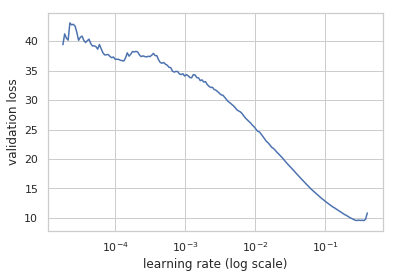

In [23]:
m.lr_find()
m.sched.plot()

In [53]:
lr = 1e-3
m.fit(lr, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error         
    0      3.139528   1.808603   1.064869  
    1      1.414394   1.12275    0.850832                    
    2      1.220433   1.036165   0.819119                    
    3      0.707036   0.491492   0.565952                     
    4      0.513051   0.327791   0.460752                     
    5      0.447095   0.304018   0.443588                     
    6      0.269977   0.150227   0.311984                     
    7      0.169735   0.102103   0.251863                     
    8      0.158449   0.095695   0.242224                     
    9      0.098798   0.049386   0.172304                     
    10     0.066464   0.035672   0.141287                      
    11     0.056851   0.033913   0.137357                      
    12     0.036649   0.025607   0.116309                      
    13     0.023851   0.022731   0.106729                      
    14     0.02334    0.02101    0.101275                      
    15   

[array([0.01701]), 0.08992334522398239]

In [54]:
m.save('finetuned-val0899')

In [55]:
m.unfreeze()
m.fit(lr, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.013959   0.019916   0.108209  
    1      0.010269   0.016035   0.088772                       
    2      0.008616   0.016005   0.087401                       
    3      0.010519   0.017954   0.092133                       
    4      0.007023   0.016521   0.08876                        
    5      0.006744   0.016866   0.089743                       
    6      0.008237   0.017949   0.093908                       
    7      0.00594    0.017546   0.091921                       
    8      0.005967   0.01696    0.092146                       
    9      0.006751   0.017775   0.092572                       
    10     0.005167   0.017404   0.09234                        
    11     0.004148   0.017263   0.092417                       
    12     0.006162   0.017977   0.092689                       
    13     0.005285   0.018374   0.094984                       
    14     0.004178   0.018261   0.095252      

[array([0.01824]), 0.09217470541607156]

In [59]:
m.load('finetuned-val0899')
m.unfreeze()
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.017604   0.017584   0.087891  
    1      0.013262   0.01739    0.088337                      
    2      0.012464   0.016457   0.087129                      
    3      0.014732   0.018986   0.094899                      
    4      0.012059   0.016684   0.089985                      
    5      0.012548   0.016091   0.087878                      
    6      0.01352    0.017692   0.092891                      
    7      0.013243   0.017251   0.088776                      
    8      0.011898   0.016373   0.088819                      
    9      0.011733   0.018623   0.096897                      
    10     0.010808   0.016354   0.090464                       
    11     0.010813   0.015884   0.08541                       
    12     0.013181   0.018663   0.100792                      
    13     0.009243   0.016388   0.08619                       
    14     0.00988    0.015911   0.085672                  

[array([0.01549]), 0.08464733585070687]

In [53]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-val0899')
m.unfreeze()
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.017162   0.018397   0.089783  
    1      0.016754   0.018083   0.089486                      
    2      0.015803   0.017665   0.087915                      
    3      0.017168   0.019299   0.092302                      
    4      0.015071   0.016353   0.084302                      
    5      0.01468    0.017361   0.086092                      
    6      0.019636   0.017832   0.094935                      
    7      0.015133   0.016775   0.089185                      
    8      0.013739   0.01646    0.085509                      
    9      0.017475   0.016337   0.087888                      
    10     0.014837   0.016945   0.084923                      
    11     0.015548   0.017051   0.085183                      
    12     0.015896   0.016694   0.085545                      
    13     0.014323   0.016988   0.084879                      
    14     0.012691   0.016324   0.08426                    

[array([0.01562]), 0.08273166418075562]

In [54]:
m.save('finetuned-all-082')

In [68]:
m.load('finetuned-val0899')
m.unfreeze()
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.019516   0.01991    0.097592  
    1      0.017287   0.018474   0.090109                      
    2      0.014695   0.017869   0.088202                      
    3      0.019001   0.018679   0.091402                      
    4      0.01538    0.016668   0.090396                      
    5      0.012635   0.017052   0.08741                       
    6      0.017275   0.020211   0.093742                      
    7      0.01471    0.02076    0.091942                      
    8      0.014929   0.016945   0.085857                      
    9      0.017354   0.017458   0.089115                      
    10     0.014012   0.016556   0.0841                        
    11     0.012987   0.016435   0.084086                      
    12     0.015374   0.018056   0.088932                      
    13     0.012957   0.017223   0.08571                       
    14     0.012345   0.01588    0.083404                   

[array([0.01636]), 0.08390791717951643]

In [69]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-val0899')
m.unfreeze()
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.023228   0.025626   0.108521  
    1      0.017223   0.018313   0.093491                      
    2      0.014395   0.018941   0.092365                      
    3      0.020299   0.019514   0.104148                      
    4      0.017949   0.018612   0.092847                      
    5      0.0153     0.018354   0.090629                      
    6      0.017865   0.018586   0.089749                      
    7      0.015649   0.017794   0.089102                      
    8      0.014086   0.017882   0.088186                      
    9      0.016344   0.017233   0.09275                       
    10     0.015141   0.017792   0.086503                      
    11     0.014536   0.017247   0.086534                      
    12     0.0174     0.017079   0.088744                      
    13     0.01456    0.016447   0.086261                      
    14     0.014575   0.016515   0.085305                   

[array([0.0164]), 0.08414461473896079]

In [17]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-val0899')
m.unfreeze()
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.019285   0.016906   0.094422  
    1      0.014819   0.018602   0.089411                      
    2      0.015131   0.0173     0.086752                      
    3      0.01634    0.019332   0.096033                      
    4      0.013444   0.017127   0.086319                      
    5      0.012157   0.016579   0.084931                      
    6      0.014503   0.024118   0.109103                      
    7      0.014206   0.016448   0.090114                      
    8      0.012028   0.016107   0.086484                      
    9      0.014471   0.016432   0.086273                      
    10     0.011143   0.016793   0.085017                      
    11     0.010875   0.01606    0.085054                      
    12     0.014118   0.018402   0.0884                        
    13     0.013014   0.016409   0.087678                      
    14     0.010881   0.016161   0.085988                   

[array([0.01529]), 0.08262233577921138]

 63%|██████▎   | 151/241 [00:00<00:00, 494.08it/s, loss=4.1]


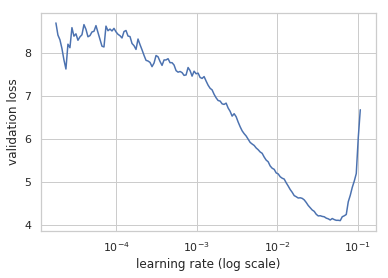

In [20]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

load_model_ignoring(m, 'test-trn018-tst043')

m.freeze_to(-1)

m.lr_find()
m.sched.plot()

In [28]:
# dropout rate
dr = 0.7

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

load_model_ignoring(m, 'test-trn018-tst043')

m.freeze_to(-1)

lr = 1e-3
m.fit(lr, 10, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error         
    0      26.185067  1.42178    0.929329  
    1      12.927978  0.79234    0.708859                    
    2      11.554868  0.693208   0.667234                    
    3      4.62365    0.236607   0.391902                    
    4      2.003862   0.153406   0.315739                    
    5      1.644321   0.14039    0.302507                    
    6      0.69242    0.072362   0.214769                     
    7      0.29484    0.05479    0.180336                     
    8      0.247451   0.052575   0.175543                     
    9      0.12732    0.045084   0.153637                     
    10     0.065656   0.040525   0.142425                      
    11     0.049277   0.041321   0.14441                       
    12     0.041035   0.036827   0.132443                      
    13     0.027443   0.033966   0.126524                      
    14     0.024446   0.034674   0.128231                      
    15     0

[array([0.02366]), 0.09970993432602439]

In [29]:
m.save('finetuned-lins_1000_500-val0997')

In [31]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-lins_1000_500-val0997')
m.unfreeze()
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.024466   0.026287   0.12682   
    1      0.015457   0.02039    0.098458                      
    2      0.012943   0.021001   0.099276                      
    3      0.020769   0.046494   0.155777                      
    4      0.015076   0.023679   0.113963                      
    5      0.011744   0.02411    0.111679                      
    6      0.019216   0.035611   0.14431                       
    7      0.012848   0.019739   0.098999                      
    8      0.011987   0.021626   0.104384                      
    9      0.017226   0.023645   0.11221                       
    10     0.012411   0.020029   0.098606                      
    11     0.009931   0.020066   0.09912                        
    12     0.013774   0.023837   0.110677                      
    13     0.011486   0.023346   0.11232                       
    14     0.00844    0.023657   0.110654                  

[array([0.01938]), 0.09855333243502759]

In [32]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-lins_1000_500-val0997')
m.unfreeze()
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.033614   0.024377   0.117336  
    1      0.019893   0.023146   0.110633                      
    2      0.01357    0.023248   0.107598                      
    3      0.035019   0.02761    0.125071                      
    4      0.017055   0.021789   0.100483                      
    5      0.01417    0.02106    0.098486                      
    6      0.027576   0.027076   0.114308                      
    7      0.016157   0.024197   0.109725                      
    8      0.013203   0.022267   0.102616                      
    9      0.021961   0.028525   0.121652                      
    10     0.016249   0.025987   0.112957                      
    11     0.011976   0.023768   0.107888                      
    12     0.021197   0.024235   0.113792                      
    13     0.014445   0.021182   0.101512                      
    14     0.01355    0.019731   0.097872                   

[array([0.02102]), 0.09665307911850174]

In [33]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-lins_1000_500-val0997')
m.freeze_to(1)
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.032958   0.033529   0.130991  
    1      0.018812   0.022466   0.105196                      
    2      0.016119   0.021669   0.101337                      
    3      0.033177   0.026173   0.115906                      
    4      0.017774   0.020677   0.101816                      
    5      0.01612    0.020052   0.097713                      
    6      0.030906   0.027743   0.117718                      
    7      0.018036   0.020995   0.102689                      
    8      0.013584   0.021195   0.101587                      
    9      0.024104   0.021383   0.10303                       
    10     0.016082   0.021152   0.101879                      
    11     0.013376   0.020868   0.09922                       
    12     0.022009   0.025428   0.110891                      
    13     0.015192   0.018616   0.091793                      
    14     0.012748   0.017278   0.087249                   

[array([0.01988]), 0.09486070770042443]

In [34]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr/10, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [1000, 500], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-lins_1000_500-val0997')
m.freeze_to(1)
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.02867    0.024406   0.111021  
    1      0.016114   0.020839   0.101778                      
    2      0.012061   0.023613   0.105959                      
    3      0.020549   0.029224   0.127821                      
    4      0.014493   0.027517   0.116803                      
    5      0.011046   0.025022   0.111885                      
    6      0.019      0.036922   0.144282                      
    7      0.014902   0.020163   0.099693                      
    8      0.010541   0.019205   0.096789                      
    9      0.019159   0.028204   0.127503                      
    10     0.011321   0.022274   0.10622                       
    11     0.010648   0.022294   0.108085                       
    12     0.015964   0.022443   0.110836                      
    13     0.012426   0.018811   0.093661                      
    14     0.008943   0.019221   0.094052                  

[array([0.01881]), 0.09677712354478685]

In [35]:
m.unfreeze()
lr=1e-3
lrs=[lr/100, lr/10, lr]
m.fit(lrs, 15, cycle_len=3, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error            
    0      0.008564   0.020098   0.100404  
    1      0.007157   0.019982   0.099726                       
    2      0.006635   0.019504   0.098065                       
    3      0.008911   0.020026   0.101369                       
    4      0.008677   0.019492   0.097606                       
    5      0.007693   0.019616   0.097643                       
    6      0.007901   0.024992   0.113276                       
    7      0.007413   0.023595   0.108221                       
    8      0.00709    0.022298   0.105144                       
    9      0.008326   0.022349   0.105955                       
    10     0.007184   0.020229   0.099998                       
    11     0.006297   0.019991   0.099361                       
    12     0.007112   0.020279   0.097539                       
    13     0.007298   0.020999   0.100172                       
    14     0.006559   0.020871   0.099599     

[array([0.02104]), 0.09933671390432287]

## Submission file

In [73]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetuned-all-082')

In [84]:
from datetime import datetime

# Make prediction.
pred = m.predict(is_test=True).squeeze()

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')

df_test_id = df_test # pd.read_csv(os.path.join(path, 'test.csv'))

submission_file  = '../submissions/{}.submission.csv'.format(now)
model_file       = '../submissions/{}.model'.format(now)

# Create a submission file.
with open(submission_file, 'w') as f:
    f.write("Id,production\n")
    for _id, _pred in zip(df_test_id.Id.values, pred):
        f.write("{},{}\n".format(_id, min(1.0, max(0.0, _pred))))

# Save model.
save_model(m.model, model_file)

[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 275, in update_class
    old_obj = getattr(old, key)
  File "/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/urllib3/packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of urllib3.co

AttributeError: 'DataFrame' object has no attribute 'Id'

In [82]:
pred = m.predict(is_test=True)
pred.squeeze()

array([0.08109, 0.24406, 0.08957, ..., 0.06683, 0.24095, 0.26506], dtype=float32)